In [1]:
# lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

# load data
train = pd.read_csv("data/train.csv", index_col=[0]) # type이 정답
test = pd.read_csv("data/test.csv", index_col=[0])
ssm = pd.read_csv("data/sample_submission.csv", index_col=[0])

# type 대응(dacon 제공)
column_number = {}
for i, column in enumerate(ssm.columns):
    column_number[column] = i

def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

print("==============================================")
print("complete load lib, data")
print("==============================================")

Using TensorFlow backend.


complete load lib, data


In [2]:
train.info()
train.describe()

go_eda = "no"
if go_eda == "no":
    print("==============================================")
    print("pass EDA, preprocessiog")
    print("==============================================")
else:
    #시각화 해보며 eda 진행
    i = 2
    print(list(train.columns)[i])
    train.loc[:,list(train.columns)[i]].plot()
    train.loc[:,train.columns[i]].sort_values()[-1:]
    train.loc[train.id == 101377, :]
    train.loc[101377, :] # type = GALAXY
    # 평균이 보통 20인데 비해 대부분의 값이 상당히 높아보임.
    i = 3
    print(list(train.columns)[i])
    train.loc[:,list(train.columns)[i]].plot()
    train.loc[:,train.columns[i]].abs().sort_values()[-30:]
    #train.loc[3991, :] # SERENDIPITY_RED
    #train.loc[80038, :] # REDDEN_STD
    #train.loc[117917, :] # SERENDIPITY_DISTANT
    train.loc[:,train.columns[i]].abs().sort_values()[-20:]
    train.loc[train.loc[:,train.columns[i]].abs().sort_values()[-20:].index,'type']
    # 모든 컬럼을 시각회 해 본 결과 아웃라이어가 너무 기존 값들과 차이나다는 점 외에는 확인할 것이 없었다.
    # 우선 아웃라이어를 변경하고(mean +- std*3, 스케일링까지 마무리 해 보자
    print("==============================================")
    print("start plt, eda, preproc")
    print("==============================================")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 199991 entries, 0 to 199990
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   type        199991 non-null  object 
 1   fiberID     199991 non-null  int64  
 2   psfMag_u    199991 non-null  float64
 3   psfMag_g    199991 non-null  float64
 4   psfMag_r    199991 non-null  float64
 5   psfMag_i    199991 non-null  float64
 6   psfMag_z    199991 non-null  float64
 7   fiberMag_u  199991 non-null  float64
 8   fiberMag_g  199991 non-null  float64
 9   fiberMag_r  199991 non-null  float64
 10  fiberMag_i  199991 non-null  float64
 11  fiberMag_z  199991 non-null  float64
 12  petroMag_u  199991 non-null  float64
 13  petroMag_g  199991 non-null  float64
 14  petroMag_r  199991 non-null  float64
 15  petroMag_i  199991 non-null  float64
 16  petroMag_z  199991 non-null  float64
 17  modelMag_u  199991 non-null  float64
 18  modelMag_g  199991 non-null  float64
 19  mo

In [2]:
out_up = train.iloc[:,2:-1].mean(axis=0) + train.iloc[:,2:-1].std(axis=0)*3
out_lo = train.iloc[:,2:-1].mean(axis=0) - train.iloc[:,2:-1].std(axis=0)*3

def nogada(data):
    for i in range(0, len(data)):
        for j in range(0, len(data.columns)):
            if data.iloc[i,j] > out_up[j]:
                data.iloc[i,j] = out_up[j]
            elif data.iloc[i,j] < out_lo[j]:
                data.iloc[i,j] = out_lo[j]
            else:
                data.iloc[i,j] = data.iloc[i,j]
    return(data)

train.iloc[:,2:-1] = nogada(train.iloc[:,2:-1])

In [4]:
test = pd.read_csv("data/test.csv", index_col=[0])
test = test.drop(columns=['fiberID'], axis=1)
test = nogada(test)

In [5]:
train.to_csv("train_nogada.csv", index=True)
test.to_csv("test_nogada.csv", index=True)

In [3]:
# 전처리하자
train = pd.read_csv("train_nogada.csv", index_col=[0]) # type이 정답
test = pd.read_csv("test_nogada.csv", index_col=[0])
test.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.552279,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,5.463231,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-444.674696,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


In [4]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(train.iloc[:,2:-1])
train.iloc[:,2:-1] = scaler.transform(train.iloc[:,2:-1])
test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
# 시각화하며 eda

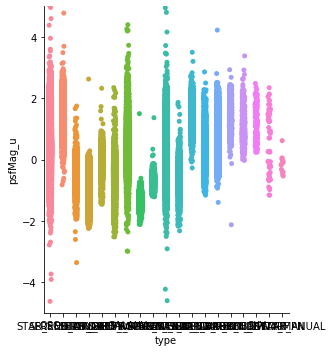

In [6]:
ax = sns.catplot(x="type", y="psfMag_u", hue="type", data=train)
ax.set(ylim=(-5, 5))
plt.show()

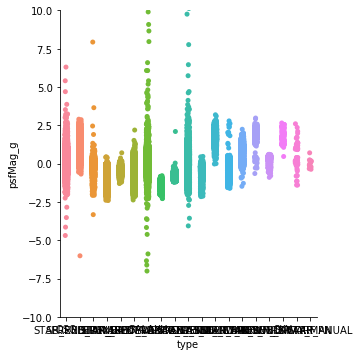

In [7]:
ax = sns.catplot(x="type", y="psfMag_g", hue="type", data=train)
ax.set(ylim=(-10, 10))
plt.show()

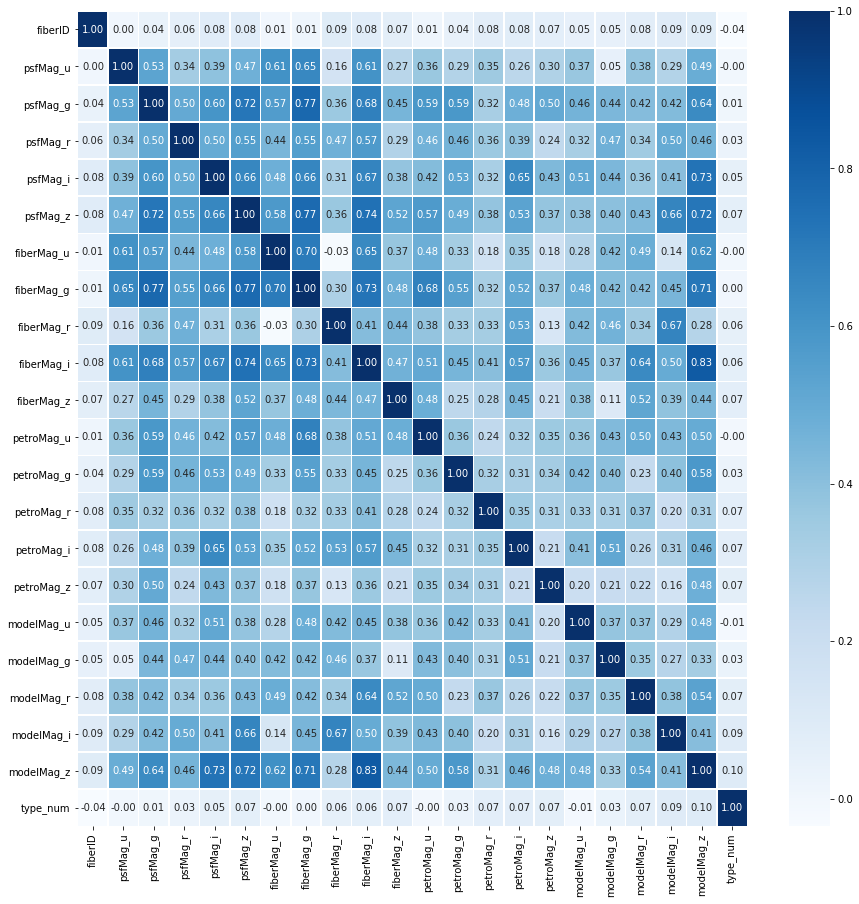

In [8]:
# 각 변수마다 비교해 봤을 때 타입간에 차이가 어느 정도 난다는 걸 확인할 수 있다.
# 변수간의 상관관계도 존재한다.
# 머신러닝을 돌릴 때에는 변수를 잘 조절해 줘야 할 듯 하다.
# 또한 트리기반 모델을 통해서 상관관계가 모델에 영향을 안주도록 해야 할 듯 하다.
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [9]:
# 최종 데이터
train_x = train.drop(columns=['fiberID', 'type', 'type_num'], axis=1)
train_y = train['type_num']
train_y_encoded = tf.keras.utils.to_categorical(train_y)

print("==============================================")
print("complete scale preproc, data preproc")
print("start modeling")
print("==============================================")

complete scale preproc, data preproc
start modeling


In [13]:
model_number = '1'
print("model number is : " + model_number)

if model_number == '1': # loss 0.35, val_loss 0.38 / 0.39, 0.37 in dropout
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=20))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='sigmoid', input_dim=20))
    model.add(Dense(19, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.summary()
    history = model.fit(train_x, train_y_encoded, epochs=200, validation_split=0.2)
elif model_number == '2': # loss 0.42, val_loss 0.39
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=20))
    #model.add(Dropout(0.5))   
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # sparse_categorical_crossentropy를 쓴다면 원핫인코딩 패스
    # model.summary()
    history = model.fit(train_x, train_y_encoded, epochs=200, validation_split=0.2)
elif model_number == '3':
    model = Sequential()
    model.add(Dense(200, activation='elu', input_dim=20))
    model.add(Dropout(0.25))   
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(19, activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # sparse_categorical_crossentropy를 쓴다면 원핫인코딩 패스
    # model.summary()
    history = model.fit(train_x, train_y_encoded, epochs=200, validation_split=0.2)    
else:
    print("no model")

print("==============================================")
print("complete modeling")
print("start prediction")
print("==============================================")

model number is : 1
Train on 159992 samples, validate on 39999 samples
Epoch 1/200
159992/159992 [==============================] - 7s 45us/step - loss: 0.7742 - accuracy: 0.7602 - val_loss: 0.5590 - val_accuracy: 0.8217
Epoch 2/200
159992/159992 [==============================] - 7s 42us/step - loss: 0.5503 - accuracy: 0.8209 - val_loss: 0.5046 - val_accuracy: 0.8351
Epoch 3/200
159992/159992 [==============================] - 7s 43us/step - loss: 0.5133 - accuracy: 0.8303 - val_loss: 0.4719 - val_accuracy: 0.8441
Epoch 4/200
159992/159992 [==============================] - 7s 46us/step - loss: 0.4932 - accuracy: 0.8357 - val_loss: 0.4569 - val_accuracy: 0.8464
Epoch 5/200
159992/159992 [==============================] - 7s 45us/step - loss: 0.4801 - accuracy: 0.8390 - val_loss: 0.4510 - val_accuracy: 0.8480
Epoch 6/200
159992/159992 [==============================] - 8s 48us/step - loss: 0.4701 - accuracy: 0.8410 - val_loss: 0.4429 - val_accuracy: 0.8513
Epoch 7/200
159992/159992 [==

Epoch 55/200
159992/159992 [==============================] - 7s 41us/step - loss: 0.4046 - accuracy: 0.8603 - val_loss: 0.3821 - val_accuracy: 0.8698
Epoch 56/200
159992/159992 [==============================] - 7s 41us/step - loss: 0.4057 - accuracy: 0.8604 - val_loss: 0.3830 - val_accuracy: 0.8697
Epoch 57/200
159992/159992 [==============================] - 7s 41us/step - loss: 0.4054 - accuracy: 0.8601 - val_loss: 0.3844 - val_accuracy: 0.8668
Epoch 58/200
159992/159992 [==============================] - 7s 41us/step - loss: 0.4052 - accuracy: 0.8600 - val_loss: 0.3850 - val_accuracy: 0.8678
Epoch 59/200
159992/159992 [==============================] - 7s 41us/step - loss: 0.4045 - accuracy: 0.8597 - val_loss: 0.3812 - val_accuracy: 0.8690
Epoch 60/200
159992/159992 [==============================] - 7s 43us/step - loss: 0.4049 - accuracy: 0.8598 - val_loss: 0.3859 - val_accuracy: 0.8682
Epoch 61/200
159992/159992 [==============================] - 8s 51us/step - loss: 0.4041 - ac

Epoch 163/200
159992/159992 [==============================] - 8s 52us/step - loss: 0.3927 - accuracy: 0.8634 - val_loss: 0.3754 - val_accuracy: 0.8720
Epoch 164/200
159992/159992 [==============================] - 9s 55us/step - loss: 0.3937 - accuracy: 0.8632 - val_loss: 0.3745 - val_accuracy: 0.8717
Epoch 165/200
159992/159992 [==============================] - 8s 49us/step - loss: 0.3923 - accuracy: 0.8635 - val_loss: 0.3742 - val_accuracy: 0.8714
Epoch 166/200
159992/159992 [==============================] - 7s 47us/step - loss: 0.3916 - accuracy: 0.8640 - val_loss: 0.3760 - val_accuracy: 0.8699
Epoch 167/200
159992/159992 [==============================] - 7s 43us/step - loss: 0.3918 - accuracy: 0.8638 - val_loss: 0.3765 - val_accuracy: 0.8723
Epoch 168/200
159992/159992 [==============================] - 7s 43us/step - loss: 0.3921 - accuracy: 0.8640 - val_loss: 0.3761 - val_accuracy: 0.8711
Epoch 169/200
159992/159992 [==============================] - 7s 43us/step - loss: 0.39

In [14]:
test_pred = model.predict(test)
submission = pd.DataFrame(test_pred, index=test.index, columns=ssm.columns)
submission.to_csv('submission_loss37.csv', index=True)
print(submission)

print("==============================================")
print("complete prediction")
print("subject submission.csv")
print("==============================================")

        STAR_WHITE_DWARF  STAR_CATY_VAR  STAR_BROWN_DWARF  SERENDIPITY_RED  \
id                                                                           
199991      2.071525e-10   6.431859e-06      1.647180e-03     6.443439e-02   
199992      3.408622e-05   5.381170e-08      9.046286e-21     3.142693e-05   
199993      1.485243e-06   2.153063e-07      7.460343e-38     2.631748e-21   
199994      5.508798e-05   4.241442e-04      2.687184e-22     1.272675e-06   
199995      6.656666e-10   2.605521e-06      5.885299e-06     2.209217e-04   
...                  ...            ...               ...              ...   
209995      5.579250e-03   2.447715e-02      2.284458e-26     3.820882e-06   
209996      1.118698e-02   6.179867e-02      5.145844e-25     4.226357e-06   
209997      1.412598e-04   2.984659e-05      3.115303e-24     7.862925e-06   
209998      4.344371e-07   2.146075e-08      2.567647e-20     2.302522e-06   
209999      1.468778e-04   7.331286e-07      8.555736e-38     1.